# Correlation Analysis: Skills, Experience & Salary

## Research Questions
1. Which skills correlate most with higher salaries?
2. Do certain skill combinations predict higher pay?
3. Is experience level the strongest salary predictor?

## Methods
- Pearson/Spearman correlation
- Partial correlation (controlling for experience)
- Correlation heatmaps

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✓ Imports complete')

✓ Imports complete


## 1. Load and Prepare Data

In [6]:
project_root = r'C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market'
df = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'jobs_with_work_type_v2.csv'), low_memory=False)

print(f"Total jobs: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

Total jobs: 46,610

Columns: ['job_id', 'title', 'company_name', 'location', 'state', 'posted_date_clean', 'year', 'month', 'quarter', 'salary_min', 'salary_max', 'salary_avg', 'has_salary', 'experience_level', 'work_type', 'is_remote', 'skills_text', 'skills_count', 'software_text', 'software_count', 'description', 'source', 'url', 'skills_extracted_text', 'skills_extracted_count']


In [7]:
# Filter to jobs with salary data
df_salary = df[df['salary_avg'].notna()].copy()

print(f"Jobs with salary data: {len(df_salary):,} ({len(df_salary)/len(df)*100:.1f}%)")
print(f"\nSalary range: ${df_salary['salary_avg'].min():,.0f} - ${df_salary['salary_avg'].max():,.0f}")
print(f"Mean salary: ${df_salary['salary_avg'].mean():,.0f}")
print(f"Median salary: ${df_salary['salary_avg'].median():,.0f}")

Jobs with salary data: 11,706 (25.1%)

Salary range: $9 - $550,000
Mean salary: $74,851
Median salary: $80,000


In [8]:
# Check suspected hourly wages
hourly_suspected = df_salary[df_salary['salary_avg'] < 100]

print(f"Jobs with salary < $100: {len(hourly_suspected):,}")
print(f"\nSample values:")
print(hourly_suspected['salary_avg'].value_counts().head(20))

# Check if they cluster around typical hourly rates ($15-$50/hr)
print(f"\nDistribution of suspected hourly wages:")
print(hourly_suspected['salary_avg'].describe())

Jobs with salary < $100: 3,624

Sample values:
salary_avg
57.5    209
30.0    165
33.5    135
32.5    108
15.0    102
20.0     99
25.0     92
60.0     91
35.0     88
22.5     86
55.0     85
17.5     80
50.0     80
12.5     78
40.0     76
27.5     72
37.5     71
45.0     70
30.5     69
65.0     68
Name: count, dtype: int64

Distribution of suspected hourly wages:
count    3624.000000
mean       40.224161
std        19.353863
min         9.000000
25%        25.000000
50%        35.000000
75%        55.000000
max        99.000000
Name: salary_avg, dtype: float64


In [9]:
# Convert hourly to annual (40 hrs/week × 52 weeks = 2080 hrs/year)
HOURS_PER_YEAR = 2080
HOURLY_THRESHOLD = 100  # Anything under $100 is likely hourly

df_salary['salary_converted'] = df_salary['salary_avg'].apply(
    lambda x: x * HOURS_PER_YEAR if x < HOURLY_THRESHOLD else x
)

# Show conversion impact
converted_count = (df_salary['salary_avg'] < HOURLY_THRESHOLD).sum()
print(f"✓ Converted {converted_count:,} hourly wages to annual")

print(f"\nBefore conversion:")
print(f"  Min: ${df_salary['salary_avg'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_avg'].mean():,.0f}")

print(f"\nAfter conversion:")
print(f"  Min: ${df_salary['salary_converted'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_converted'].mean():,.0f}")

# Use converted salary going forward
df_salary['salary_avg'] = df_salary['salary_converted']
df_salary = df_salary.drop(columns=['salary_converted'])

✓ Converted 3,624 hourly wages to annual

Before conversion:
  Min: $9
  Mean: $74,851

After conversion:
  Min: $100
  Mean: $100,741


In [10]:
# Analyze salary distribution for outliers
import numpy as np

print("\nSALARY DISTRIBUTION ANALYSIS")
print("="*60)

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = df_salary['salary_avg'].quantile(p/100)
    print(f"{p:2}th percentile: ${val:>10,.0f}")

print("\n" + "="*60)

# Check extreme values
low_outliers = df_salary[df_salary['salary_avg'] < 30000]
print(f"\nJobs with salary < $30k: {len(low_outliers):,} ({len(low_outliers)/len(df_salary)*100:.1f}%)")

high_outliers = df_salary[df_salary['salary_avg'] > 200000]
print(f"Jobs with salary > $200k: {len(high_outliers):,} ({len(high_outliers)/len(df_salary)*100:.1f}%)")


SALARY DISTRIBUTION ANALYSIS
 1th percentile: $    20,800
 5th percentile: $    39,666
10th percentile: $    47,840
25th percentile: $    68,640
50th percentile: $    94,496
75th percentile: $   124,800
90th percentile: $   160,000
95th percentile: $   189,541
99th percentile: $   242,229


Jobs with salary < $30k: 267 (2.3%)
Jobs with salary > $200k: 447 (3.8%)


In [11]:
# Clean salary outliers
SALARY_MIN = 30000
SALARY_MAX = 200000

df_salary = df_salary[
    (df_salary['salary_avg'] >= SALARY_MIN) & 
    (df_salary['salary_avg'] <= SALARY_MAX)
].copy()

print(f"\n✓ Cleaned to salary range: ${SALARY_MIN:,} - ${SALARY_MAX:,}")
print(f"✓ Remaining jobs: {len(df_salary):,}")
print(f"✓ New mean: ${df_salary['salary_avg'].mean():,.0f}")
print(f"✓ New median: ${df_salary['salary_avg'].median():,.0f}")


✓ Cleaned to salary range: $30,000 - $200,000
✓ Remaining jobs: 10,992
✓ New mean: $97,381
✓ New median: $93,600


## 2. Create Skill Binary Columns

In [12]:
# Parse skills from skills_extracted_text column
def create_skill_columns(df):
    """Create binary columns for each skill"""
    
    # Get all unique skills
    all_skills = set()
    for skills_text in df['skills_extracted_text'].dropna():
        if skills_text:
            skills = [s.strip() for s in skills_text.split(',')]
            all_skills.update(skills)
    
    print(f"Found {len(all_skills)} unique skills")
    
    # Create binary columns
    for skill in sorted(all_skills):
        df[f'skill_{skill}'] = df['skills_extracted_text'].str.contains(
            skill, case=False, na=False
        ).astype(int)
    
    return df, sorted(all_skills)

df_salary, skills_list = create_skill_columns(df_salary)

print(f"\nCreated {len(skills_list)} skill columns")
print(f"Sample skills: {skills_list[:10]}")

Found 43 unique skills

Created 43 skill columns
Sample skills: ['a/b testing', 'agile', 'airflow', 'api', 'aws', 'azure', 'bigquery', 'business intelligence', 'data modeling', 'data visualization']


In [13]:
# Check skill prevalence
skill_cols = [f'skill_{s}' for s in skills_list]
skill_counts = df_salary[skill_cols].sum().sort_values(ascending=False)

print("Top 20 Most Common Skills:")
for col, count in skill_counts.head(20).items():
    skill_name = col.replace('skill_', '')
    pct = (count / len(df_salary)) * 100
    print(f"{skill_name:30} | {count:5,} jobs ({pct:5.1f}%)")

Top 20 Most Common Skills:
r                              | 3,268 jobs ( 29.7%)
sql                            | 2,621 jobs ( 23.8%)
business intelligence          | 1,971 jobs ( 17.9%)
excel                          | 1,760 jobs ( 16.0%)
python                         | 1,554 jobs ( 14.1%)
statistics                     | 1,436 jobs ( 13.1%)
tableau                        | 1,430 jobs ( 13.0%)
power bi                       | 1,306 jobs ( 11.9%)
data visualization             | 1,013 jobs (  9.2%)
machine learning               |   721 jobs (  6.6%)
etl                            |   625 jobs (  5.7%)
data warehouse                 |   538 jobs (  4.9%)
agile                          |   495 jobs (  4.5%)
data modeling                  |   491 jobs (  4.5%)
aws                            |   410 jobs (  3.7%)
oracle                         |   371 jobs (  3.4%)
sas                            |   362 jobs (  3.3%)
snowflake                      |   346 jobs (  3.1%)
azure              

## 3. Encode Experience Level

In [16]:
# Create numeric experience level (CORRECTED)
experience_mapping = {
    'Entry': 1,
    'Mid': 2,
    'Senior': 3,
    'Lead': 4,
    'Executive': 5,
    'Not Specified': np.nan
}

df_salary['experience_numeric'] = df_salary['experience_level'].map(experience_mapping)

# Filter to jobs with experience level
df_analysis = df_salary[df_salary['experience_numeric'].notna()].copy()

print(f"Jobs with both salary and experience: {len(df_analysis):,}")
print(f"\nExperience distribution:")
print(df_analysis['experience_level'].value_counts())

Jobs with both salary and experience: 10,966

Experience distribution:
experience_level
Mid       8329
Senior    2339
Entry      298
Name: count, dtype: int64


## 4. Skills vs Salary Correlation

In [17]:
# Calculate correlation for each skill
skill_correlations = []

for skill in skills_list:
    col = f'skill_{skill}'
    
    # Only calculate if skill appears in at least 20 jobs
    if df_analysis[col].sum() < 20:
        continue
    
    # Pearson correlation
    corr, p_value = pearsonr(df_analysis[col], df_analysis['salary_avg'])
    
    # Mean salary comparison
    with_skill = df_analysis[df_analysis[col] == 1]['salary_avg'].mean()
    without_skill = df_analysis[df_analysis[col] == 0]['salary_avg'].mean()
    salary_diff = with_skill - without_skill
    
    skill_correlations.append({
        'skill': skill,
        'correlation': corr,
        'p_value': p_value,
        'n_jobs': df_analysis[col].sum(),
        'mean_salary_with': with_skill,
        'mean_salary_without': without_skill,
        'salary_premium': salary_diff,
        'premium_pct': (salary_diff / without_skill * 100) if without_skill > 0 else 0
    })

corr_df = pd.DataFrame(skill_correlations).sort_values('correlation', ascending=False)

print(f"\nAnalyzed {len(corr_df)} skills with 20+ occurrences")


Analyzed 42 skills with 20+ occurrences


In [18]:
# Top skills positively correlated with salary
print("\n" + "="*80)
print("TOP 15 SKILLS CORRELATED WITH HIGHER SALARY")
print("="*80)

for idx, row in corr_df.head(15).iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")


TOP 15 SKILLS CORRELATED WITH HIGHER SALARY
machine learning          | r=+0.105*** | Premium: $ 15,646 (+16.2%) |   720 jobs
python                    | r=+0.091*** | Premium: $  9,608 (+10.0%) | 1,553 jobs
aws                       | r=+0.087*** | Premium: $ 16,952 (+17.5%) |   410 jobs
spark                     | r=+0.084*** | Premium: $ 22,453 (+23.2%) |   212 jobs
etl                       | r=+0.072*** | Premium: $ 11,445 (+11.8%) |   624 jobs
snowflake                 | r=+0.063*** | Premium: $ 13,252 (+13.7%) |   346 jobs
oracle                    | r=+0.062*** | Premium: $ 12,706 (+13.1%) |   370 jobs
azure                     | r=+0.060*** | Premium: $ 12,771 (+13.2%) |   342 jobs
data warehouse            | r=+0.057*** | Premium: $  9,815 (+10.1%) |   537 jobs
r                         | r=+0.057*** | Premium: $  4,617 ( +4.8%) | 3,262 jobs
redshift                  | r=+0.054*** | Premium: $ 18,785 (+19.3%) |   127 jobs
scala                     | r=+0.049*** | Premium: $ 

In [19]:
# Bottom skills (negative correlation)
print("\n" + "="*80)
print("SKILLS CORRELATED WITH LOWER SALARY")
print("="*80)

for idx, row in corr_df.tail(10).iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Penalty: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")


SKILLS CORRELATED WITH LOWER SALARY
api                       | r=+0.002    | Penalty: $    782 ( +0.8%) |   141 jobs
data visualization        | r=-0.002    | Penalty: $   -233 ( -0.2%) | 1,012 jobs
mysql                     | r=-0.007    | Penalty: $ -2,761 ( -2.8%) |    85 jobs
power bi                  | r=-0.012    | Penalty: $ -1,422 ( -1.5%) | 1,303 jobs
statistics                | r=-0.015    | Penalty: $ -1,700 ( -1.7%) | 1,434 jobs
sas                       | r=-0.018    | Penalty: $ -3,822 ( -3.9%) |   362 jobs
javascript                | r=-0.020*   | Penalty: $ -6,154 ( -6.3%) |   155 jobs
qlik                      | r=-0.024*   | Penalty: $ -8,382 ( -8.6%) |   129 jobs
google sheets             | r=-0.056*** | Penalty: $-20,137 (-20.6%) |   119 jobs
excel                     | r=-0.138*** | Penalty: $-13,956 (-14.0%) | 1,757 jobs


In [20]:
# Visualize top correlations
top_n = 20
plot_df = pd.concat([
    corr_df.head(top_n//2),
    corr_df.tail(top_n//2)
]).sort_values('correlation')

fig = go.Figure(go.Bar(
    x=plot_df['correlation'],
    y=plot_df['skill'],
    orientation='h',
    marker=dict(
        color=plot_df['correlation'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Correlation")
    ),
    text=plot_df['correlation'].apply(lambda x: f'{x:+.3f}'),
    textposition='outside'
))

fig.update_layout(
    title='Skills Most/Least Correlated with Salary',
    xaxis_title='Correlation Coefficient',
    yaxis_title='',
    height=600,
    template='plotly_dark'
)

fig.show()

## 5. Experience Level vs Salary

In [21]:
# Experience level correlation
exp_corr, exp_p = pearsonr(df_analysis['experience_numeric'], df_analysis['salary_avg'])

print(f"\nExperience Level Correlation with Salary:")
print(f"Pearson r = {exp_corr:.3f} (p < 0.001)")
print(f"\nThis is {'STRONGER' if abs(exp_corr) > corr_df['correlation'].abs().max() else 'WEAKER'} than any individual skill")


Experience Level Correlation with Salary:
Pearson r = 0.332 (p < 0.001)

This is STRONGER than any individual skill


In [24]:
# Salary by experience level (Entry to Senior only)
exp_salary = df_analysis.groupby('experience_level')['salary_avg'].agg(['mean', 'median', 'count']).round(0)
exp_salary = exp_salary.reindex(['Entry', 'Mid', 'Senior'])

print("\nSalary by Experience Level:")
print("="*60)
print(exp_salary)


Salary by Experience Level:
                      mean    median  count
experience_level                           
Entry              83412.0   75119.0    298
Mid                91007.0   86239.0   8329
Senior            121688.0  119101.0   2339


In [25]:
# Visualize experience vs salary
fig = px.box(
    df_analysis,
    x='experience_level',
    y='salary_avg',
    category_orders={'experience_level': ['Entry Level', 'Mid Level', 'Senior Level', 'Lead', 'Executive']},
    title='Salary Distribution by Experience Level',
    labels={'salary_avg': 'Average Salary ($)', 'experience_level': 'Experience Level'},
    template='plotly_dark'
)

fig.update_traces(marker=dict(color='lightblue'))
fig.show()

## 6. Partial Correlation (Controlling for Experience)

In [47]:
# Check all skills and software tools in your dataset
print(skills_list)
print(f"\nTotal: {len(skills_list)} skills")

print("\n")
print(software_corrs['skill'].sort_values().tolist())
print(f"\nTotal: {len(software_corrs)} software tools")

['a/b testing', 'agile', 'airflow', 'api', 'aws', 'azure', 'bigquery', 'business intelligence', 'data modeling', 'data visualization', 'data warehouse', 'dbt', 'etl', 'excel', 'gcp', 'git', 'google sheets', 'hadoop', 'java', 'javascript', 'kafka', 'looker', 'machine learning', 'mongodb', 'mysql', 'numpy', 'oracle', 'pandas', 'postgresql', 'power bi', 'python', 'qlik', 'r', 'redshift', 'regression', 'sas', 'scala', 'snowflake', 'spark', 'sql', 'sql server', 'statistics', 'tableau']

Total: 43 skills


['airflow', 'aws', 'azure', 'dbt', 'gcp', 'git', 'hadoop', 'oracle', 'python', 'r', 'redshift', 'scala', 'snowflake', 'spark']

Total: 14 software tools


In [48]:
# Categorize skills into Software vs General Skills
software_skills = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery', 
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git' 
]

general_skills = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl', 
    'data warehouse', 'data modeling', 'agile', 'api'
]

# Separate correlations
software_corrs = partial_df[partial_df['skill'].isin(software_skills)].copy()
general_corrs = partial_df[partial_df['skill'].isin(general_skills)].copy()

print(f"Software/Tools: {len(software_corrs)} skills")
print(f"General Skills: {len(general_corrs)} skills")

Software/Tools: 14 skills
General Skills: 6 skills


In [49]:
print("\n" + "="*80)
print("SOFTWARE/TOOLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(software_corrs)} software/tools, showing top 10")
print("="*80)

for idx, row in software_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")


SOFTWARE/TOOLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 14 software/tools, showing top 10
python                    | Regular: +0.091 | Partial: +0.087 | Diff: +0.003
spark                     | Regular: +0.084 | Partial: +0.079 | Diff: +0.004
aws                       | Regular: +0.087 | Partial: +0.076 | Diff: +0.011
azure                     | Regular: +0.060 | Partial: +0.057 | Diff: +0.003
r                         | Regular: +0.057 | Partial: +0.048 | Diff: +0.009
redshift                  | Regular: +0.054 | Partial: +0.047 | Diff: +0.008
snowflake                 | Regular: +0.063 | Partial: +0.045 | Diff: +0.018
git                       | Regular: +0.043 | Partial: +0.042 | Diff: +0.001
airflow                   | Regular: +0.040 | Partial: +0.041 | Diff: -0.001
hadoop                    | Regular: +0.048 | Partial: +0.038 | Diff: +0.010


In [51]:
print("\n" + "="*80)
print("GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(general_corrs)} general skills, showing top 10")
print("="*80)

for idx, row in general_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")


GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 6 general skills, showing top 10
machine learning          | Regular: +0.105 | Partial: +0.099 | Diff: +0.006
etl                       | Regular: +0.072 | Partial: +0.055 | Diff: +0.017
regression                | Regular: +0.044 | Partial: +0.038 | Diff: +0.005
data warehouse            | Regular: +0.057 | Partial: +0.036 | Diff: +0.021
data modeling             | Regular: +0.042 | Partial: +0.036 | Diff: +0.007
business intelligence     | Regular: +0.040 | Partial: +0.020 | Diff: +0.019


In [38]:
# Compare software vs general skills
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Software/Tools',
    x=software_corrs.sort_values('partial_correlation', ascending=False).head(10)['skill'],
    y=software_corrs.sort_values('partial_correlation', ascending=False).head(10)['partial_correlation'],
    marker_color='#4CAF50'
))

fig.add_trace(go.Bar(
    name='General Skills',
    x=general_corrs.sort_values('partial_correlation', ascending=False)['skill'],
    y=general_corrs.sort_values('partial_correlation', ascending=False)['partial_correlation'],
    marker_color='#FFC107'
))

fig.update_layout(
    title='Software vs General Skills: Independent Effect on Salary<br><sub>Partial Correlation (Controlling for Experience)</sub>',
    xaxis_title='Skill',
    yaxis_title='Partial Correlation',
    template='plotly_dark',
    height=500,
    barmode='group'
)

fig.show()

In [39]:
# Compare average effects
print("\n" + "="*80)
print("SOFTWARE vs GENERAL SKILLS COMPARISON")
print("="*80)

print(f"\nSoftware/Tools (n={len(software_corrs)}):")
print(f"  Mean partial correlation: {software_corrs['partial_correlation'].mean():+.3f}")
print(f"  Strongest: {software_corrs.nlargest(1, 'partial_correlation').iloc[0]['skill']} "
      f"(r={software_corrs.nlargest(1, 'partial_correlation').iloc[0]['partial_correlation']:+.3f})")

print(f"\nGeneral Skills (n={len(general_corrs)}):")
print(f"  Mean partial correlation: {general_corrs['partial_correlation'].mean():+.3f}")
print(f"  Strongest: {general_corrs.nlargest(1, 'partial_correlation').iloc[0]['skill']} "
      f"(r={general_corrs.nlargest(1, 'partial_correlation').iloc[0]['partial_correlation']:+.3f})")

print(f"\n→ {'Software/Tools' if software_corrs['partial_correlation'].mean() > general_corrs['partial_correlation'].mean() else 'General Skills'} "
      f"have stronger independent effect on salary")


SOFTWARE vs GENERAL SKILLS COMPARISON

Software/Tools (n=14):
  Mean partial correlation: +0.050
  Strongest: python (r=+0.087)

General Skills (n=6):
  Mean partial correlation: +0.048
  Strongest: machine learning (r=+0.099)

→ Software/Tools have stronger independent effect on salary


In [27]:
# Calculate partial correlation for top skills
def partial_correlation(x, y, z):
    """Calculate partial correlation between x and y, controlling for z"""
    r_xy = np.corrcoef(x, y)[0, 1]
    r_xz = np.corrcoef(x, z)[0, 1]
    r_yz = np.corrcoef(y, z)[0, 1]
    
    numerator = r_xy - (r_xz * r_yz)
    denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
    
    return numerator / denominator if denominator != 0 else 0

# Calculate for top 20 skills
partial_corrs = []

for idx, row in corr_df.head(20).iterrows():
    skill_col = f'skill_{row["skill"]}'
    
    # Regular correlation
    regular_corr = row['correlation']
    
    # Partial correlation (controlling for experience)
    partial_corr = partial_correlation(
        df_analysis[skill_col].values,
        df_analysis['salary_avg'].values,
        df_analysis['experience_numeric'].values
    )
    
    partial_corrs.append({
        'skill': row['skill'],
        'regular_correlation': regular_corr,
        'partial_correlation': partial_corr,
        'difference': regular_corr - partial_corr
    })

partial_df = pd.DataFrame(partial_corrs)

In [28]:
print("\n" + "="*80)
print("PARTIAL CORRELATION (Controlling for Experience Level)")
print("="*80)
print("\nSkills with INDEPENDENT effect on salary (after controlling for experience):\n")

for idx, row in partial_df.sort_values('partial_correlation', ascending=False).head(15).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")


PARTIAL CORRELATION (Controlling for Experience Level)

Skills with INDEPENDENT effect on salary (after controlling for experience):

machine learning          | Regular: +0.105 | Partial: +0.099 | Diff: +0.006
python                    | Regular: +0.091 | Partial: +0.087 | Diff: +0.003
spark                     | Regular: +0.084 | Partial: +0.079 | Diff: +0.004
aws                       | Regular: +0.087 | Partial: +0.076 | Diff: +0.011
azure                     | Regular: +0.060 | Partial: +0.057 | Diff: +0.003
etl                       | Regular: +0.072 | Partial: +0.055 | Diff: +0.017
r                         | Regular: +0.057 | Partial: +0.048 | Diff: +0.009
redshift                  | Regular: +0.054 | Partial: +0.047 | Diff: +0.008
snowflake                 | Regular: +0.063 | Partial: +0.045 | Diff: +0.018
git                       | Regular: +0.043 | Partial: +0.042 | Diff: +0.001
airflow                   | Regular: +0.040 | Partial: +0.041 | Diff: -0.001
regression        

## 7. Skill Combinations

In [29]:
# Analyze top skill combinations
from itertools import combinations

# Get top 10 skills by correlation
top_skills = corr_df.head(10)['skill'].tolist()

# Analyze 2-skill combinations
combo_results = []

for skill1, skill2 in combinations(top_skills, 2):
    col1 = f'skill_{skill1}'
    col2 = f'skill_{skill2}'
    
    # Jobs with both skills
    both = df_analysis[(df_analysis[col1] == 1) & (df_analysis[col2] == 1)]
    
    if len(both) >= 10:  # At least 10 jobs
        # Jobs with only skill1
        only1 = df_analysis[(df_analysis[col1] == 1) & (df_analysis[col2] == 0)]
        # Jobs with only skill2
        only2 = df_analysis[(df_analysis[col1] == 0) & (df_analysis[col2] == 1)]
        # Jobs with neither
        neither = df_analysis[(df_analysis[col1] == 0) & (df_analysis[col2] == 0)]
        
        combo_results.append({
            'skill1': skill1,
            'skill2': skill2,
            'n_both': len(both),
            'salary_both': both['salary_avg'].mean(),
            'salary_only1': only1['salary_avg'].mean() if len(only1) > 0 else 0,
            'salary_only2': only2['salary_avg'].mean() if len(only2) > 0 else 0,
            'salary_neither': neither['salary_avg'].mean() if len(neither) > 0 else 0
        })

combo_df = pd.DataFrame(combo_results)
combo_df['combo_premium'] = combo_df['salary_both'] - combo_df['salary_neither']
combo_df = combo_df.sort_values('salary_both', ascending=False)

In [30]:
print("\n" + "="*80)
print("TOP 15 SKILL COMBINATIONS BY AVERAGE SALARY")
print("="*80)

for idx, row in combo_df.head(15).iterrows():
    print(f"{row['skill1']:20} + {row['skill2']:20} | "
          f"${row['salary_both']:>8,.0f} | "
          f"+${row['combo_premium']:>7,.0f} premium | "
          f"{row['n_both']:>4,.0f} jobs")


TOP 15 SKILL COMBINATIONS BY AVERAGE SALARY
spark                + azure                | $ 127,267 | +$ 30,618 premium |   54 jobs
spark                + snowflake            | $ 126,890 | +$ 30,371 premium |   17 jobs
etl                  + oracle               | $ 126,111 | +$ 29,624 premium |   92 jobs
aws                  + spark                | $ 123,958 | +$ 27,522 premium |   71 jobs
oracle               + data warehouse       | $ 123,793 | +$ 27,152 premium |   91 jobs
machine learning     + spark                | $ 123,015 | +$ 26,916 premium |  100 jobs
spark                + data warehouse       | $ 122,315 | +$ 25,834 premium |   33 jobs
machine learning     + aws                  | $ 120,959 | +$ 25,041 premium |  127 jobs
machine learning     + azure                | $ 120,828 | +$ 24,746 premium |   91 jobs
aws                  + azure                | $ 120,151 | +$ 23,614 premium |  113 jobs
python               + spark                | $ 119,706 | +$ 23,784 premium

## 8. Correlation Heatmap

In [31]:
# Create correlation matrix for top skills + salary + experience
top_20_skills = corr_df.head(20)['skill'].tolist()
skill_cols_subset = [f'skill_{s}' for s in top_20_skills]

# Select columns for correlation
corr_cols = skill_cols_subset + ['experience_numeric', 'salary_avg']
corr_matrix = df_analysis[corr_cols].corr()

# Rename for readability
rename_dict = {f'skill_{s}': s for s in top_20_skills}
rename_dict['experience_numeric'] = 'Experience Level'
rename_dict['salary_avg'] = 'Salary'
corr_matrix = corr_matrix.rename(columns=rename_dict, index=rename_dict)

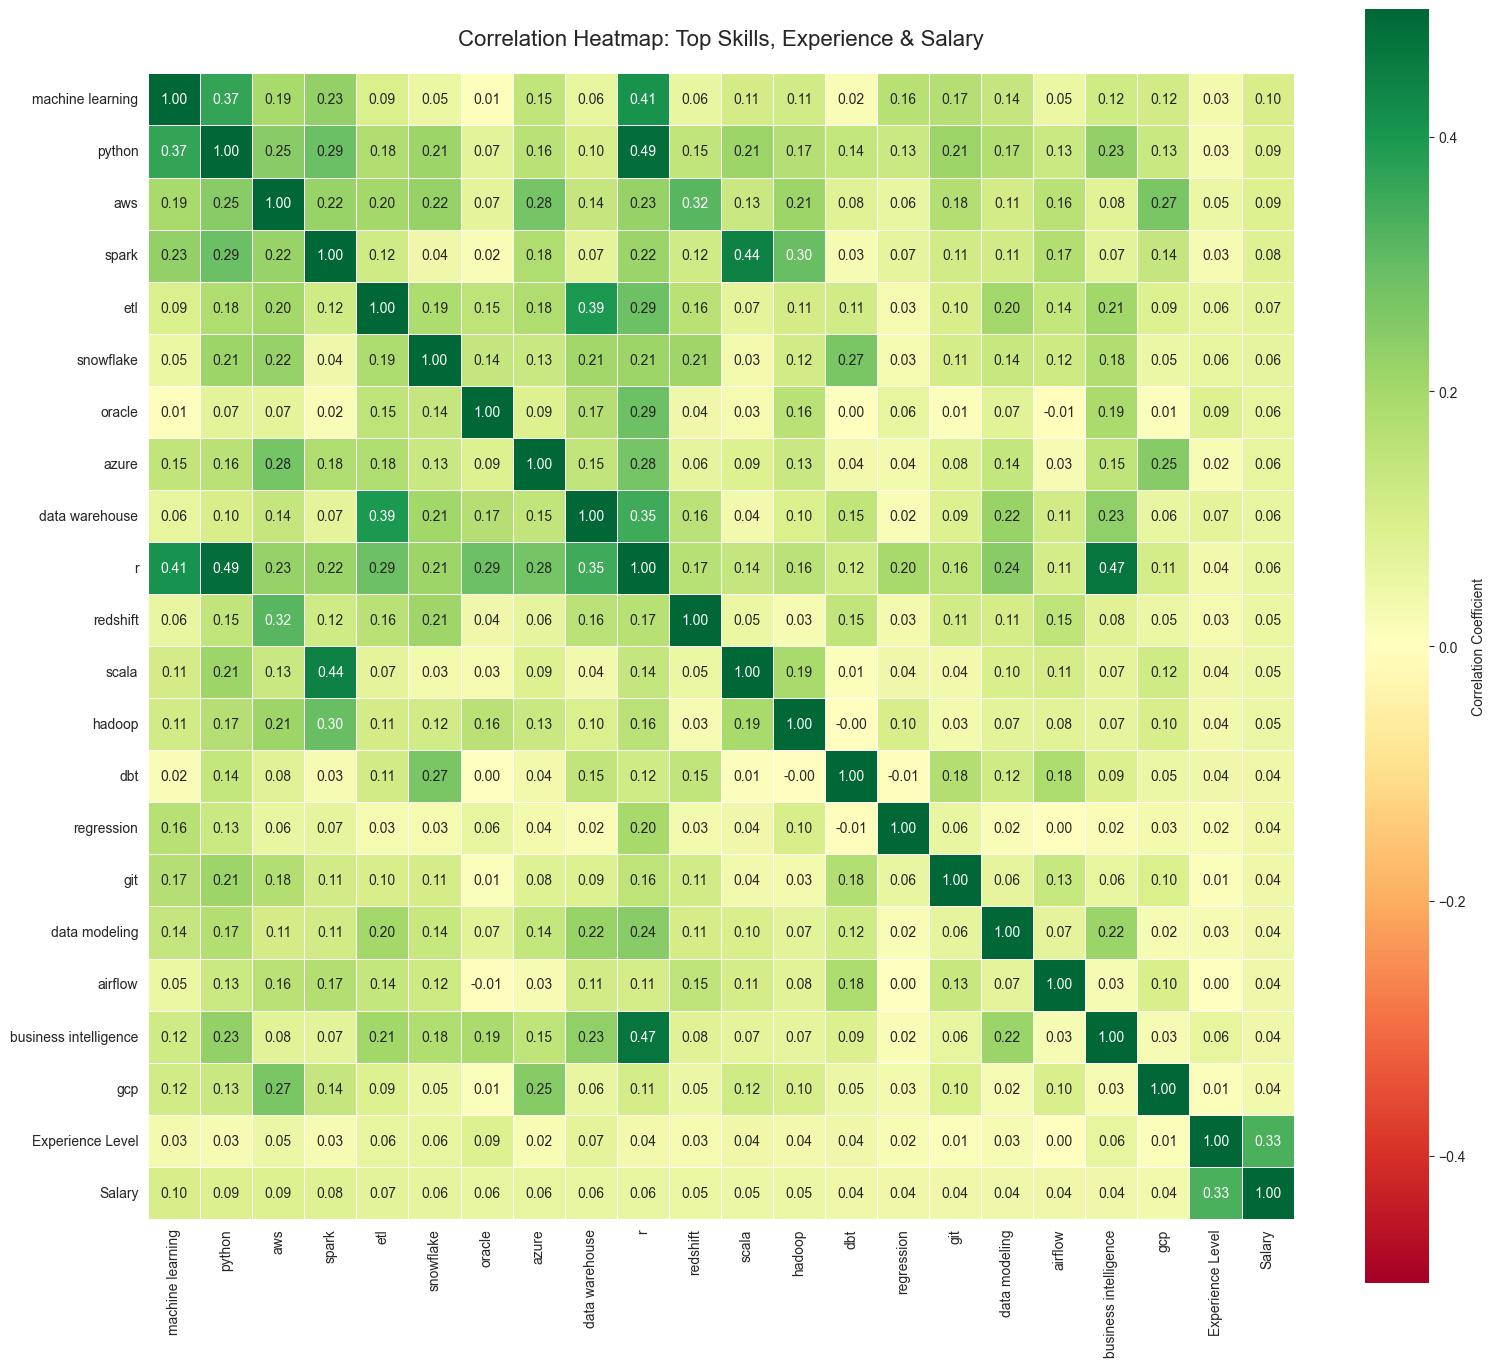


✓ Heatmap saved to visualizations/correlation_heatmap.png


In [32]:
# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap: Top Skills, Experience & Salary', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('../visualizations/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmap saved to visualizations/correlation_heatmap.png")

## 9. Key Findings Summary

In [33]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# 1. Strongest predictor
top_skill_corr = corr_df.iloc[0]['correlation']
print(f"\n1. STRONGEST SALARY PREDICTOR:")
print(f"   Experience Level: r = {exp_corr:.3f}")
print(f"   Top Skill ({corr_df.iloc[0]['skill']}): r = {top_skill_corr:.3f}")
print(f"   → Experience is {'STRONGER' if abs(exp_corr) > abs(top_skill_corr) else 'WEAKER'}")

# 2. Top value skills
print(f"\n2. TOP 5 HIGH-VALUE SKILLS:")
for idx, row in corr_df.head(5).iterrows():
    print(f"   {row['skill']:20} → +${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%)")

# 3. Skills independent of experience
print(f"\n3. SKILLS WITH INDEPENDENT EFFECT (after controlling for experience):")
for idx, row in partial_df.nlargest(5, 'partial_correlation').iterrows():
    print(f"   {row['skill']:20} → Partial r = {row['partial_correlation']:+.3f}")

# 4. Best skill combo
best_combo = combo_df.iloc[0]
print(f"\n4. HIGHEST-PAYING SKILL COMBINATION:")
print(f"   {best_combo['skill1']} + {best_combo['skill2']}")
print(f"   → ${best_combo['salary_both']:,.0f} average salary")
print(f"   → +${best_combo['combo_premium']:,.0f} premium over no skills")

print("\n" + "="*80)


KEY FINDINGS

1. STRONGEST SALARY PREDICTOR:
   Experience Level: r = 0.332
   Top Skill (machine learning): r = 0.105
   → Experience is STRONGER

2. TOP 5 HIGH-VALUE SKILLS:
   machine learning     → +$ 15,646 (+16.2%)
   python               → +$  9,608 (+10.0%)
   aws                  → +$ 16,952 (+17.5%)
   spark                → +$ 22,453 (+23.2%)
   etl                  → +$ 11,445 (+11.8%)

3. SKILLS WITH INDEPENDENT EFFECT (after controlling for experience):
   machine learning     → Partial r = +0.099
   python               → Partial r = +0.087
   spark                → Partial r = +0.079
   aws                  → Partial r = +0.076
   azure                → Partial r = +0.057

4. HIGHEST-PAYING SKILL COMBINATION:
   spark + azure
   → $127,267 average salary
   → +$30,618 premium over no skills



## 10. Export Results

In [34]:
# Save correlation results
corr_df.to_csv('../data/processed/skill_salary_correlations.csv', index=False)
combo_df.to_csv('../data/processed/skill_combinations_analysis.csv', index=False)
partial_df.to_csv('../data/processed/partial_correlations.csv', index=False)

print("\n✓ Results exported to data/processed/")
print("  - skill_salary_correlations.csv")
print("  - skill_combinations_analysis.csv")
print("  - partial_correlations.csv")


✓ Results exported to data/processed/
  - skill_salary_correlations.csv
  - skill_combinations_analysis.csv
  - partial_correlations.csv
